In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import re
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics, model_selection

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Dense,
    Embedding,
    LSTM,
    GlobalMaxPooling1D,
    Conv1D,
    Dropout,
    Bidirectional,
)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

<IPython.core.display.Javascript object>

In [3]:
warnings.filterwarnings("ignore")
print("Tensorflow version =", tf.__version__)

Tensorflow version = 2.3.1


<IPython.core.display.Javascript object>

# 1-D CNN

## Setup

In [4]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print("No GPUs detected")

1 Physical GPUs, 1 Logical GPUs


<IPython.core.display.Javascript object>

In [5]:
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print("Mixed precision enabled")

Mixed precision enabled


<IPython.core.display.Javascript object>

In [6]:
args = dict(
    data_dir=Path("../input"),
    train_csv=Path("../input/train.csv"),
    test_csv=Path("../input/test_x.csv"),
    sample_csv=Path("../input/sample_submission.csv"),
    target_col="author",
    feature_dir=Path("../build/feature"),
    val_dir=Path("../build/val"),
    test_dir=Path("../build/test"),
    subm_dir=Path("../build/subm"),
    n_folds=5,
    n_classes=5,
    seed=42,
)

<IPython.core.display.Javascript object>

In [8]:
algo_name = "cnn"
feature_name = "emb"
model_name = f"{algo_name}_{feature_name}"

p_val_file = args["val_dir"] / f"{model_name}.val.csv"
p_test_file = args["test_dir"] / f"{model_name}.test.csv"
subm_file = args["subm_dir"] / f"{model_name}.csv"

<IPython.core.display.Javascript object>

## Data

In [9]:
train = pd.read_csv(args["train_csv"], index_col=0)
train.head()

,text,author
index,,
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3


<IPython.core.display.Javascript object>

In [10]:
test = pd.read_csv(args["test_csv"], index_col=0)
test.head()

,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


<IPython.core.display.Javascript object>

## Preprocessing

In [11]:
def alpha_num(text):
    return re.sub(r"[^A-Za-z0-9 ]", "", text)


def remove_stopwords(text):
    final_text = []
    for token in text.split():
        if token.strip().lower() not in STOPWORDS:
            final_text.append(token.strip())
    return " ".join(final_text)


STOPWORDS = [
    "a",
    "about",
    "above",
    "after",
    "again",
    "against",
    "all",
    "am",
    "an",
    "and",
    "any",
    "are",
    "as",
    "at",
    "be",
    "because",
    "been",
    "before",
    "being",
    "below",
    "between",
    "both",
    "but",
    "by",
    "could",
    "did",
    "do",
    "does",
    "doing",
    "down",
    "during",
    "each",
    "few",
    "for",
    "from",
    "further",
    "had",
    "has",
    "have",
    "having",
    "he",
    "he'd",
    "he'll",
    "he's",
    "her",
    "here",
    "here's",
    "hers",
    "herself",
    "him",
    "himself",
    "his",
    "how",
    "how's",
    "i",
    "i'd",
    "i'll",
    "i'm",
    "i've",
    "if",
    "in",
    "into",
    "is",
    "it",
    "it's",
    "its",
    "itself",
    "let's",
    "me",
    "more",
    "most",
    "my",
    "myself",
    "nor",
    "of",
    "on",
    "once",
    "only",
    "or",
    "other",
    "ought",
    "our",
    "ours",
    "ourselves",
    "out",
    "over",
    "own",
    "same",
    "she",
    "she'd",
    "she'll",
    "she's",
    "should",
    "so",
    "some",
    "such",
    "than",
    "that",
    "that's",
    "the",
    "their",
    "theirs",
    "them",
    "themselves",
    "then",
    "there",
    "there's",
    "these",
    "they",
    "they'd",
    "they'll",
    "they're",
    "they've",
    "this",
    "those",
    "through",
    "to",
    "too",
    "under",
    "until",
    "up",
    "very",
    "was",
    "we",
    "we'd",
    "we'll",
    "we're",
    "we've",
    "were",
    "what",
    "what's",
    "when",
    "when's",
    "where",
    "where's",
    "which",
    "while",
    "who",
    "who's",
    "whom",
    "why",
    "why's",
    "with",
    "would",
    "you",
    "you'd",
    "you'll",
    "you're",
    "you've",
    "your",
    "yours",
    "yourself",
    "yourselves",
]

<IPython.core.display.Javascript object>

In [12]:
train["text"] = train["text"].str.lower().apply(alpha_num).apply(remove_stopwords)
test["text"] = test["text"].str.lower().apply(alpha_num).apply(remove_stopwords)

<IPython.core.display.Javascript object>

In [15]:
x_trn = train["text"].values
x_test = test["text"].values
y = train["author"].values
x_trn.shape, x_test.shape, y.shape

((54879,), (19617,), (54879,))

<IPython.core.display.Javascript object>

## Train

In [16]:
vocab_sz = 20_000
embed_dim = 64
maxlen = 500
padding = "post"

<IPython.core.display.Javascript object>

In [17]:
tokenizer = Tokenizer(num_words=vocab_sz)
tokenizer.fit_on_texts(x_trn)
word_index = tokenizer.word_index

<IPython.core.display.Javascript object>

In [18]:
trn_seqs = tokenizer.texts_to_sequences(x_trn)
test_seqs = tokenizer.texts_to_sequences(x_test)

<IPython.core.display.Javascript object>

In [19]:
trn = pad_sequences(trn_seqs, padding=padding, maxlen=maxlen)
test = pad_sequences(test_seqs, padding=padding, maxlen=maxlen)
trn.shape, test.shape

((54879, 500), (19617, 500))

<IPython.core.display.Javascript object>

In [20]:
cv = model_selection.StratifiedKFold(
    n_splits=args["n_folds"], shuffle=True, random_state=args["seed"]
)

<IPython.core.display.Javascript object>

In [21]:
def get_model():
    model = Sequential(
        [
            Embedding(vocab_sz, embed_dim, input_length=maxlen),
            Dropout(0.5),
            Conv1D(128, 7, padding="valid", activation="relu", strides=3),
            Conv1D(128, 7, padding="valid", activation="relu", strides=3),
            GlobalMaxPooling1D(),
            Dense(128, activation="relu"),
            Dropout(0.5),
            Dense(args["n_classes"], activation="softmax"),
        ]
    )

    # compile model
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.005))

    return model

<IPython.core.display.Javascript object>

In [22]:
p_val = np.zeros((trn.shape[0], args["n_classes"]))
p_test = np.zeros((test.shape[0], args["n_classes"]))

for fold, (trn_, val_) in enumerate(cv.split(trn, y)):
    print(f"Training model for CV #{fold}...")

    x_trn, y_trn = trn[trn_], y[trn_]
    x_val, y_val = trn[val_], y[val_]
    y_trn = to_categorical(y_trn)
    y_val = to_categorical(y_val)

    model = get_model()

    es = EarlyStopping(
        monitor="val_loss",
        min_delta=0.001,
        patience=3,
        verbose=1,
        mode="min",
        baseline=None,
        restore_best_weights=True,
    )
    model.fit(
        x_trn,
        y_trn,
        validation_data=(x_val, y_val),
        epochs=10,
        batch_size=512,
        callbacks=[es],
    )

    p_val[val_] = model.predict(x_val)
    p_test += model.predict(test) / args["n_folds"]

Training model for CV #0...
Epoch 1/10
86/86 [==============================] - 4s 52ms/step - loss: 1.3580 - val_loss: 1.0120
Epoch 2/10
86/86 [==============================] - 4s 50ms/step - loss: 0.8825 - val_loss: 0.8269
Epoch 3/10
86/86 [==============================] - 4s 50ms/step - loss: 0.6577 - val_loss: 0.7884
Epoch 4/10
86/86 [==============================] - 4s 50ms/step - loss: 0.5312 - val_loss: 0.8130
Epoch 5/10
86/86 [==============================] - 4s 50ms/step - loss: 0.4520 - val_loss: 0.8426
Epoch 6/10
86/86 [==============================] - 4s 50ms/step - loss: 0.4017 - val_loss: 0.8812
Epoch 00006: early stopping
Training model for CV #1...
Epoch 1/10
86/86 [==============================] - 4s 51ms/step - loss: 1.3794 - val_loss: 1.1029
Epoch 2/10
86/86 [==============================] - 4s 50ms/step - loss: 0.9146 - val_loss: 0.8357
Epoch 3/10
86/86 [==============================] - 4s 50ms/step - loss: 0.6612 - val_loss: 0.7958
Epoch 4/10
86/86 [=======

<IPython.core.display.Javascript object>

In [26]:
print(f"Accuracy (CV): {metrics.accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%")
print(f"Log Loss (CV): {metrics.log_loss(pd.get_dummies(y), p_val):8.4f}")

Accuracy (CV):  70.8395%
Log Loss (CV):   0.7933


<IPython.core.display.Javascript object>

In [27]:
np.savetxt(p_val_file, p_val, fmt="%.6f", delimiter=",")
np.savetxt(p_test_file, p_test, fmt="%.6f", delimiter=",")

<IPython.core.display.Javascript object>

## Visualization

In [23]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 64)           1280000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 500, 64)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 165, 128)          57472     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 53, 128)           114816    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)              

<IPython.core.display.Javascript object>

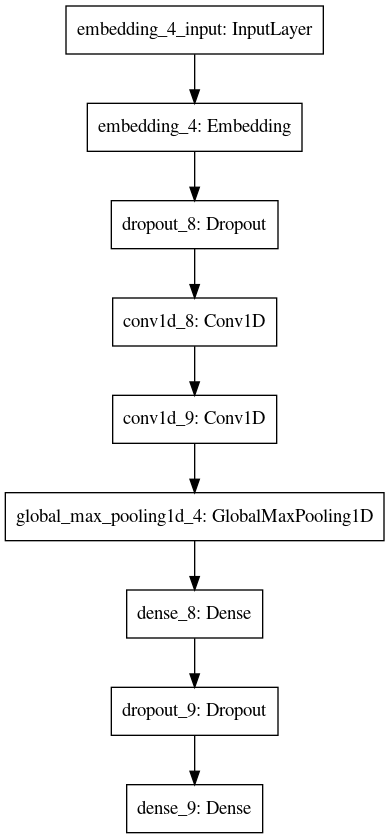

<IPython.core.display.Javascript object>

In [24]:
plot_model(model)

## Submission

In [28]:
subm = pd.read_csv(args["sample_csv"], index_col=0)
subm[subm.columns] = p_test
subm.head()

,0,1,2,3,4
index,,,,,
0,0.098581,0.102833,0.343329,0.388452,0.066806
1,0.126339,0.452102,0.072354,0.019616,0.329589
2,0.991563,0.005941,0.000299,0.000084,0.002113
3,0.005721,0.009020,0.815859,0.006990,0.162410
4,0.519385,0.105615,0.134162,0.085068,0.155771


<IPython.core.display.Javascript object>

In [29]:
subm.to_csv(subm_file)

<IPython.core.display.Javascript object>